In [35]:
import pandas as pd
import requests
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
import numpy as np
from collections import Counter
import utils


In [36]:
# Setting default parameters for all charts
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'darkblue'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelcolor'] = 'gray'

# Other optional settings for consistent styling
plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legend
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size

# To apply grid and color consistency
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.grid'] = True

plt.style.use('ggplot')
pd.set_option('display.max_columns',None)

In [37]:

def getRoadFeatures(lat:float, lon:float) -> tuple:

    """
    Retrieves road features from OpenStreetMap (OSM) data using the Overpass API based on specified latitude and longitude.

    Parameters:
    ----------
    lat : float
        The latitude of the traffic counter installed on the road to query.
    lon : float
        The longitude of the traffic counter installed on the road to query.

    Returns:
    -------
    tuple
        A tuple containing the following road features (values may be `None` if not found):
        - lanes : int or None
            Total number of lanes on the road, if available.
        - forward_lanes : int or None
            Number of lanes in the forward direction, if available.
        - backward_lanes : int or None
            Number of lanes in the backward direction, if available.
        - width : str or None
            The width of the road, if specified.
        - maxspeed : str or None
            The maximum speed limit on the road, if specified.
        - oneway : str or None
            Indicates if the road is one-way (`"yes"` or `"no"`), if available.
        - carriageway_type : str or None
            Type of carriageway (e.g., `"residential"`, `"highway"`, etc.), if specified.

    Notes:
    ------
    - The function uses a 5-meter radius around the provided coordinates to search for nearby roads.
    - Extracted attributes are returned as-is from OSM data and may vary based on local tagging.
    
    """

    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    way(around:5,{lat},{lon})["highway"];
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    lanes = None
    forward_lanes=None
    backward_lanes=None
    width = None
    maxspeed = None  # Initialize maxspeed variable
    oneway = None    # Initialize oneway variable
    carriageway_type = None  # Initialize carriageway type variable

    # Extract lanes, width, and maxspeed information from the response
    if data['elements']:
        for element in data['elements']:
            if 'tags' in element:
                tags = element['tags']
                
                
                # Extract lanes information
                if 'lanes' in tags:
                    lanes = tags['lanes']
                if 'lanes:forward' in tags:
                    # Calculate total lanes if forward/backward data is present
                    forward_lanes = int(tags.get('lanes:forward', 0))
                if 'lanes:backward' in tags:
                    backward_lanes = int(tags.get('lanes:backward', 0))
                
                # Extract width information
                if 'width' in tags:
                    width = tags['width']
                
                # Extract maxspeed information
                if 'maxspeed' in tags:
                    maxspeed = tags['maxspeed']
                # Extract oneway information
                if 'oneway' in tags:
                    oneway = tags['oneway']
                
                # Extract carriageway type
                if 'highway' in tags:
                    carriageway_type = tags['highway']

    return lanes,forward_lanes,backward_lanes, width, maxspeed, oneway, carriageway_type


# Apply the function to the dataset
def extractRoadnformation(df:pd.DataFrame)-> pd.DataFrame:

    """
    Extracts detailed road features from OpenStreetMap (OSM) for each traffic counter in the provided DataFrame.

    This function uses the `getRoadFeatures` helper function to retrieve road attributes (e.g., lanes, width, speed limit) 
    from OSM based on the latitude and longitude coordinates for each record in the input DataFrame. 
    It appends these attributes as new columns to the DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame containing traffic counter data, with each row representing a unique counter.
        Required columns:
        - `latitude`: Latitude of the counter's location.
        - `longitude`: Longitude of the counter's location.

    Returns:
    -------
    pd.DataFrame
        The original DataFrame with additional columns for road features:
        - `lanes`: Total number of lanes on the road, if available.
        - `fwd_lanes`: Number of lanes in the forward direction, if available.
        - `bkwd_lanes`: Number of lanes in the backward direction, if available.
        - `width`: The width of the road, if specified.
        - `max_speed`: The maximum speed limit on the road, if specified.
        - `oneway`: Indicates if the road is one-way (`"yes"` or `"no"`), if available.
        - `carriageway_type`: Type of carriageway (e.g., `"residential"`, `"highway"`, etc.), if specified.

    Notes:
    ------
    - This function iterates over each row in the DataFrame and queries OSM data for each counter's location.
    - The function may be slowed down by API limits if used with many locations. Consider using a delay.
    - Retrieved OSM data may vary by location, so some attributes may be missing (filled as `None`).
    """


    lanes_info = []
    f_lanes_info = []
    b_lanes_info = []
    width_info = []
    mspeed_info = []
    oneway_info = []
    carriageway_info = []
    
    for idx, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        lanes,flanes,blanes, width,mspeed, oneway, carriageway_type = getRoadFeatures(lat, lon)
        lanes_info.append(lanes)
        f_lanes_info.append(flanes)
        b_lanes_info.append(blanes) 
        width_info.append(width)
        mspeed_info.append(mspeed)
        oneway_info.append(oneway)
        carriageway_info.append(carriageway_type)
        #time.sleep(1)  # Be polite with API usage
    
    df['lanes'] = lanes_info
    df['fwd_lanes'] = f_lanes_info
    df['bkwd_lanes'] = b_lanes_info
    df['width'] = width_info
    df['max_speed']=mspeed_info
    df['oneway'] = oneway_info
    df['carriageway_type'] = carriageway_info
    return df

## 1. Data Engineering (Traffic Counter Point Data)

In [3]:
fname='count_points.csv'
df_count=pd.read_csv(f'data/{fname}') # Reading traffic counter metadata
df_count.head()

,count_point_id,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,lanes,width,fwd_lanes,bkwd_lanes,max_speed,std_lane_width_meters,oneway,carriageway_type
0,998097,6,London,108,Wandsworth,C,Minor,NaN,NaN,525020,173960,51.450833,-0.202202,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
1,998071,6,London,108,Wandsworth,U,Minor,NaN,NaN,523303,174410,51.455254,-0.226743,NaN,NaN,2.0,NaN,NaN,NaN,32,3.0,NaN,residential
2,998065,6,London,108,Wandsworth,B237,Minor,NaN,NaN,528100,173968,51.450217,-0.157899,NaN,NaN,NaN,NaN,NaN,NaN,32,3.0,NaN,secondary
3,990355,6,London,108,Wandsworth,C,Minor,NaN,NaN,526080,174220,51.452935,-0.186863,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
4,953192,6,London,108,Wandsworth,U,Minor,NaN,NaN,528346,175841,51.466994,-0.153682,NaN,NaN,1.0,NaN,NaN,NaN,32,3.0,NaN,residential


In [4]:
df_count.isna().any() # Checking for NA values (particularly for GPS Coordinates)

count_point_id              False
region_id                   False
region_name                 False
local_authority_id          False
local_authority_name        False
road_name                   False
road_type                   False
start_junction_road_name     True
end_junction_road_name       True
easting                     False
northing                    False
latitude                    False
longitude                   False
link_length_km               True
link_length_miles            True
lanes                        True
width                        True
fwd_lanes                    True
bkwd_lanes                   True
max_speed                   False
std_lane_width_meters       False
oneway                       True
carriageway_type             True
dtype: bool

In [ ]:

df_count = extractRoadnformation(df_count) # Extracting road features (e.g., number of lanes, max speed, forward lanes, backward lanes, road width). These features have been extracted but are not currently used due to insufficient data. They are kept here to be utilized if additional data becomes available in the future.
df_count['max_speed'].fillna('0 mph',inplace=True) # Filling na values for max_speed with '0 mph' to process this feature
df_count['max_speed']=df_count['max_speed'].apply(lambda x: round(int(x.replace(' mph',''))*1.60934)) # Covnverting mph to kmh
replace_with_none = ['footway', 'pedestrian', 'tertiary', 'cycleway', 'path', 'service'] # OSM overpass API gets the road features based on the provided GPS points. Inaccurate GPS points may lead to fetching wrong details. Excluding any uneccearry details
df_count['carriageway_type']=df_count['carriageway_type'].apply(lambda x: None if x in replace_with_none else x)
df_count['std_lane_width_meters']=df_count.apply(lambda x: 3.5 if x['road_type']=='Major' else 3,axis=1) # Adding a feature standard lane width following the design manual for roads and bridges
df_count.head()

In [451]:
fname='count_points.csv'
df_count.to_csv(f'data/{fname}',index=False) # Saving Data

# 2. Data Engineering (Raw Count Data)

In [51]:
def getTotalCars(row:pd.DataFrame)->float:
     
    """
    Calculates the total number of Passenger Car Equivalents (PCE) for various types of vehicles on the road.

    This function uses Passenger Car Equivalent (PCE) values to convert diverse vehicle types 
    (e.g., bicycles, motorbikes, buses, and trucks) into an equivalent measure based on the 
    impact of a single passenger car. This allows for standardized comparison of mixed-traffic flow.

    Parameters:
    ----------
    row : pd.DataFrame
        A DataFrame row containing vehicle count data with specific columns for each vehicle type 
        (e.g., `pedal_cycles`, `two_wheeled_motor_vehicles`, `cars_and_taxis`, etc.).

    Returns:
    -------
    float
        The total Passenger Car Equivalent (PCE) count for the input vehicles, providing a measure 
        of traffic flow impact in terms of passenger car units.

    Notes:
    ------
    PCE factors used for different vehicles:
    - pedal_cycles: 0.2
    - two_wheeled_motor_vehicles: 0.6
    - cars_and_taxis: 1.0
    - buses_and_coaches: 2.5
    - lgvs (Light Goods Vehicles): 1.2
    - hgvs with various axles: ranging from 1.8 to 4.2

    The specific values may vary based on region or local guidelines in traffic engineering.
    """

    total_cars=(row['pedal_cycles'] * utils.PEDAL_CYCLES
                +row['two_wheeled_motor_vehicles'] * utils.TWO_WHEELED_MOTOR_VEHICLES
                +row['cars_and_taxis'] * utils.CARS_AND_TAXIS
                +row['buses_and_coaches'] * utils.BUSES_AND_COACHES
                +row['lgvs'] * utils.LGVS
                +row['hgvs_2_rigid_axle'] * utils.HGVS_2_RIGID_AXLE
                +row['hgvs_3_rigid_axle'] * utils.HGVS_3_RIGID_AXLE
                +row['hgvs_4_or_more_rigid_axle'] * utils.HGVS_4_OR_MORE_RIGID_AXLE
                +row['hgvs_3_or_4_articulated_axle'] * utils.HGVS_3_OR_4_ARTICULATED_AXLE
                +row['hgvs_5_articulated_axle'] * utils.HGVS_5_ARTICULATED_AXLE
                +row['hgvs_6_articulated_axle'] * utils.HGVS_6_ARTICULATED_AXLE)
    return total_cars

def getRoadCapacity(row):
    road_capacity_info = {
    "A": {
        "description": "Primary Roads (Arterial)",
        "typical_lanes": "2 lanes",
        "capacity_per_lane": "1,500–2,000 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_A
    },
    "B": {
        "description": "Secondary Roads (Collector roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "800–1,500 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_B
    },
    "U": {
        "description": "Unclassified Roads (Minor local roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_U
    },
    "C": {
        "description": "Local/Residential Roads",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_C
    }
}
    

    return road_capacity_info[row['road_classification']]['avg_capacity_per_lane']


In [70]:
df=pd.read_csv('data/raw_count.csv',parse_dates=['count_date']) # Reading Raw Count Data
count_df=pd.read_csv('data/count_points.csv') # Reading processed count point data
count_df=count_df[count_df['count_point_id'].isin(df['count_point_id'].unique())]
count_df

,count_point_id,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,lanes,width,fwd_lanes,bkwd_lanes,max_speed,std_lane_width_meters,oneway,carriageway_type
0,998097,6,London,108,Wandsworth,C,Minor,NaN,NaN,525020,173960,51.450833,-0.202202,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
1,998071,6,London,108,Wandsworth,U,Minor,NaN,NaN,523303,174410,51.455254,-0.226743,NaN,NaN,2.0,NaN,NaN,NaN,32,3.0,NaN,residential
2,998065,6,London,108,Wandsworth,B237,Minor,NaN,NaN,528100,173968,51.450217,-0.157899,NaN,NaN,NaN,NaN,NaN,NaN,32,3.0,NaN,secondary
3,990355,6,London,108,Wandsworth,C,Minor,NaN,NaN,526080,174220,51.452935,-0.186863,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
4,953192,6,London,108,Wandsworth,U,Minor,NaN,NaN,528346,175841,51.466994,-0.153682,NaN,NaN,1.0,NaN,NaN,NaN,32,3.0,NaN,residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,7571,6,London,108,Wandsworth,A3036,Major,A3220,LA Boundary,528000,175600,51.464905,-0.158747,0.8,0.50,NaN,NaN,NaN,NaN,0,3.5,NaN,NaN
118,6774,6,London,108,Wandsworth,A217,Major,A24,A3,526600,172000,51.432866,-0.180177,4.2,2.61,NaN,NaN,NaN,NaN,0,3.5,NaN,NaN
119,6757,6,London,108,Wandsworth,A205,Major,A219,A3,524500,174850,51.458945,-0.209369,1.1,0.68,2.0,NaN,NaN,NaN,32,3.5,NaN,trunk
120,6111,6,London,108,Wandsworth,A3,Major,A205,A218,525000,174600,51.456588,-0.202264,0.4,0.25,NaN,NaN,NaN,NaN,0,3.5,no,NaN


In [71]:

df[['region_id','region_name','local_authority_id','local_authority_name']].nunique()

region_id               1
region_name             1
local_authority_id      1
local_authority_name    1
dtype: int64

In [72]:
# Dropping columns 'region_id', 'region_name', 'local_authority_id', 'local_authority_name' as each has a single unique value,
# which will not contribute to the model's predictive power.
df.drop(columns=['region_id','region_name','local_authority_id','local_authority_name'],inplace=True)

# Applying the function 'getTotalCars' across each row to calculate 'total_cars' based on Passenger Car Equivalent (PCE) values,
# a standard measure in traffic engineering to represent vehicle counts in terms of equivalent car units.
df['total_cars']=df.apply(getTotalCars,axis=1) 
df['road_classification']=df['road_name'].apply(lambda x: x[0]) # Getting the road classification (A, B, C, U)
df['avg_road_capacity']=df.apply(getRoadCapacity,axis=1) # Calculating average road capacity depending upon the road classification as per UK Design Manual for Roads and Bridges (DMRB)
df['congestion_ratio']=df['total_cars']/df['avg_road_capacity'] # Calculating road congestion based on the total cars/hour and average road capacity 

df[df['count_point_id']==36928]

,count_point_id,direction_of_travel,year,count_date,hour,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio
3936,36928,N,2000,2000-07-13,7,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,13,23,425,20,174,26,3,1,1,1,1,33,675,767.6,A,1750,0.438629
3937,36928,N,2000,2000-07-13,8,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,4,38,417,13,103,18,1,0,0,2,0,21,592,638.8,A,1750,0.365029
3938,36928,N,2000,2000-07-13,9,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,5,16,378,25,108,33,2,5,5,5,3,53,580,704.8,A,1750,0.402743
3939,36928,N,2000,2000-07-13,10,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,1,17,437,30,106,21,3,1,2,4,2,33,623,726.3,A,1750,0.415029
3940,36928,N,2000,2000-07-13,11,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,1,14,418,21,111,30,1,1,2,1,1,36,600,685.3,A,1750,0.391600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,36928,N,2012,2012-10-26,10,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,11,33,631,22,181,31,5,11,1,0,2,50,917,1034.7,A,1750,0.591257
4076,36928,N,2012,2012-10-26,11,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,9,21,376,18,189,23,7,13,0,2,4,49,653,780.3,A,1750,0.445886
4077,36928,N,2012,2012-10-26,12,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,3,15,581,16,171,13,3,7,0,0,1,24,807,889.9,A,1750,0.508514
4078,36928,N,2012,2012-10-26,13,A306,Major,A3(T),B306,522100,175000,51.460817,-0.243845,2.6,1.62,8,11,466,19,163,18,2,4,0,1,1,26,685,773.4,A,1750,0.441943


## 3. Exploratory Data Analysis


In [100]:

# Creating a summary DataFrame 'tdf' to analyze year data availability for each unique road count point.
# The code groups data by 'count_point_id' and collects all unique years of data availability for each point.

tdf=pd.DataFrame(df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
tdf[tdf['max_year']>2013]
tdf

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2002, 2011, 2016, 2021]",4,2002,2021
1,6111,"[2004, 2009, 2010, 2012, 2013, 2017, 2021]",7,2004,2021
2,6757,"[2007, 2011, 2017]",3,2007,2017
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",12,2000,2022
4,7571,"[2002, 2012, 2020]",3,2002,2020
...,...,...,...,...,...
106,953192,"[2000, 2001, 2002, 2003, 2004, 2005, 2007, 200...",9,2000,2009
107,990355,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
108,998065,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
109,998071,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",9,2000,2009


### 3.1 Trends in Sensor Data Availability Over Time (2000-2023)

The plot titled "Data Availability Over Time Across Sensors" illustrates the number of sensors (out of a total of 111) with data available for each year from 2000 to 2023. The x-axis represents each year, while the y-axis shows the count of sensors reporting data in that year. A fluctuating blue line with labeled points highlights the variation in data availability, peaking at 46 sensors in a particular year, while other years, such as around 2015 and 2020, show a notable decline in sensor coverage. This plot provides a clear view of data availability trends over time, showing periods of extensive data collection contrasted with years where fewer sensors contributed data.

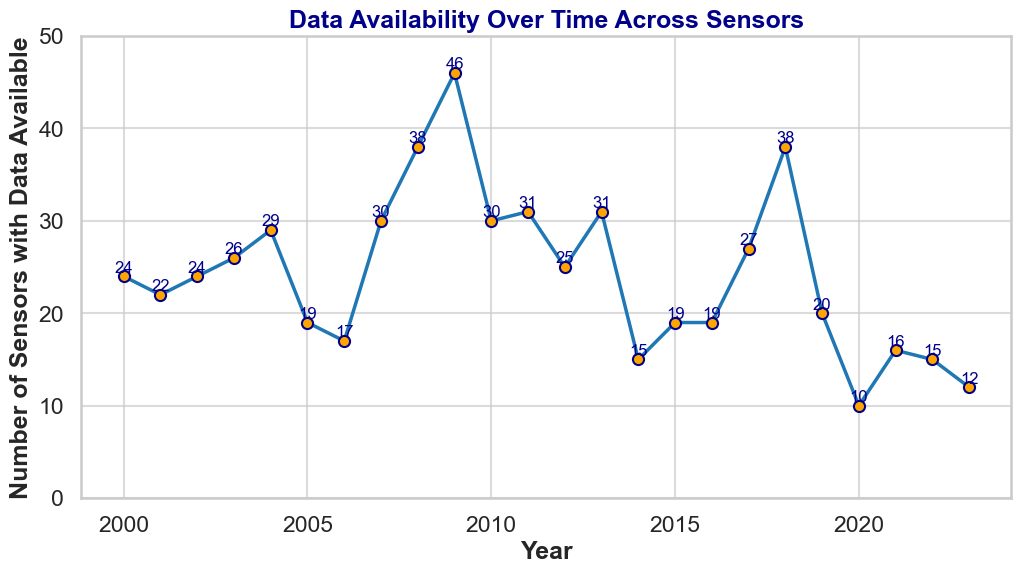

In [64]:
# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

### 3.2 Data Availability Across Sensors by Year
The following heatmap illustrates the presence or absence of data for each sensor (count_point_id) from 2000 to 2023. The x-axis represents each year within this range, while the y-axis lists the unique sensor IDs. Each cell in the grid shows a black box if data is available for a specific sensor in a particular year, and a white box if data is absent. This visualization provides a quick overview of data coverage across time for each sensor, making it easy to identify patterns, gaps, and periods of continuous data availability.

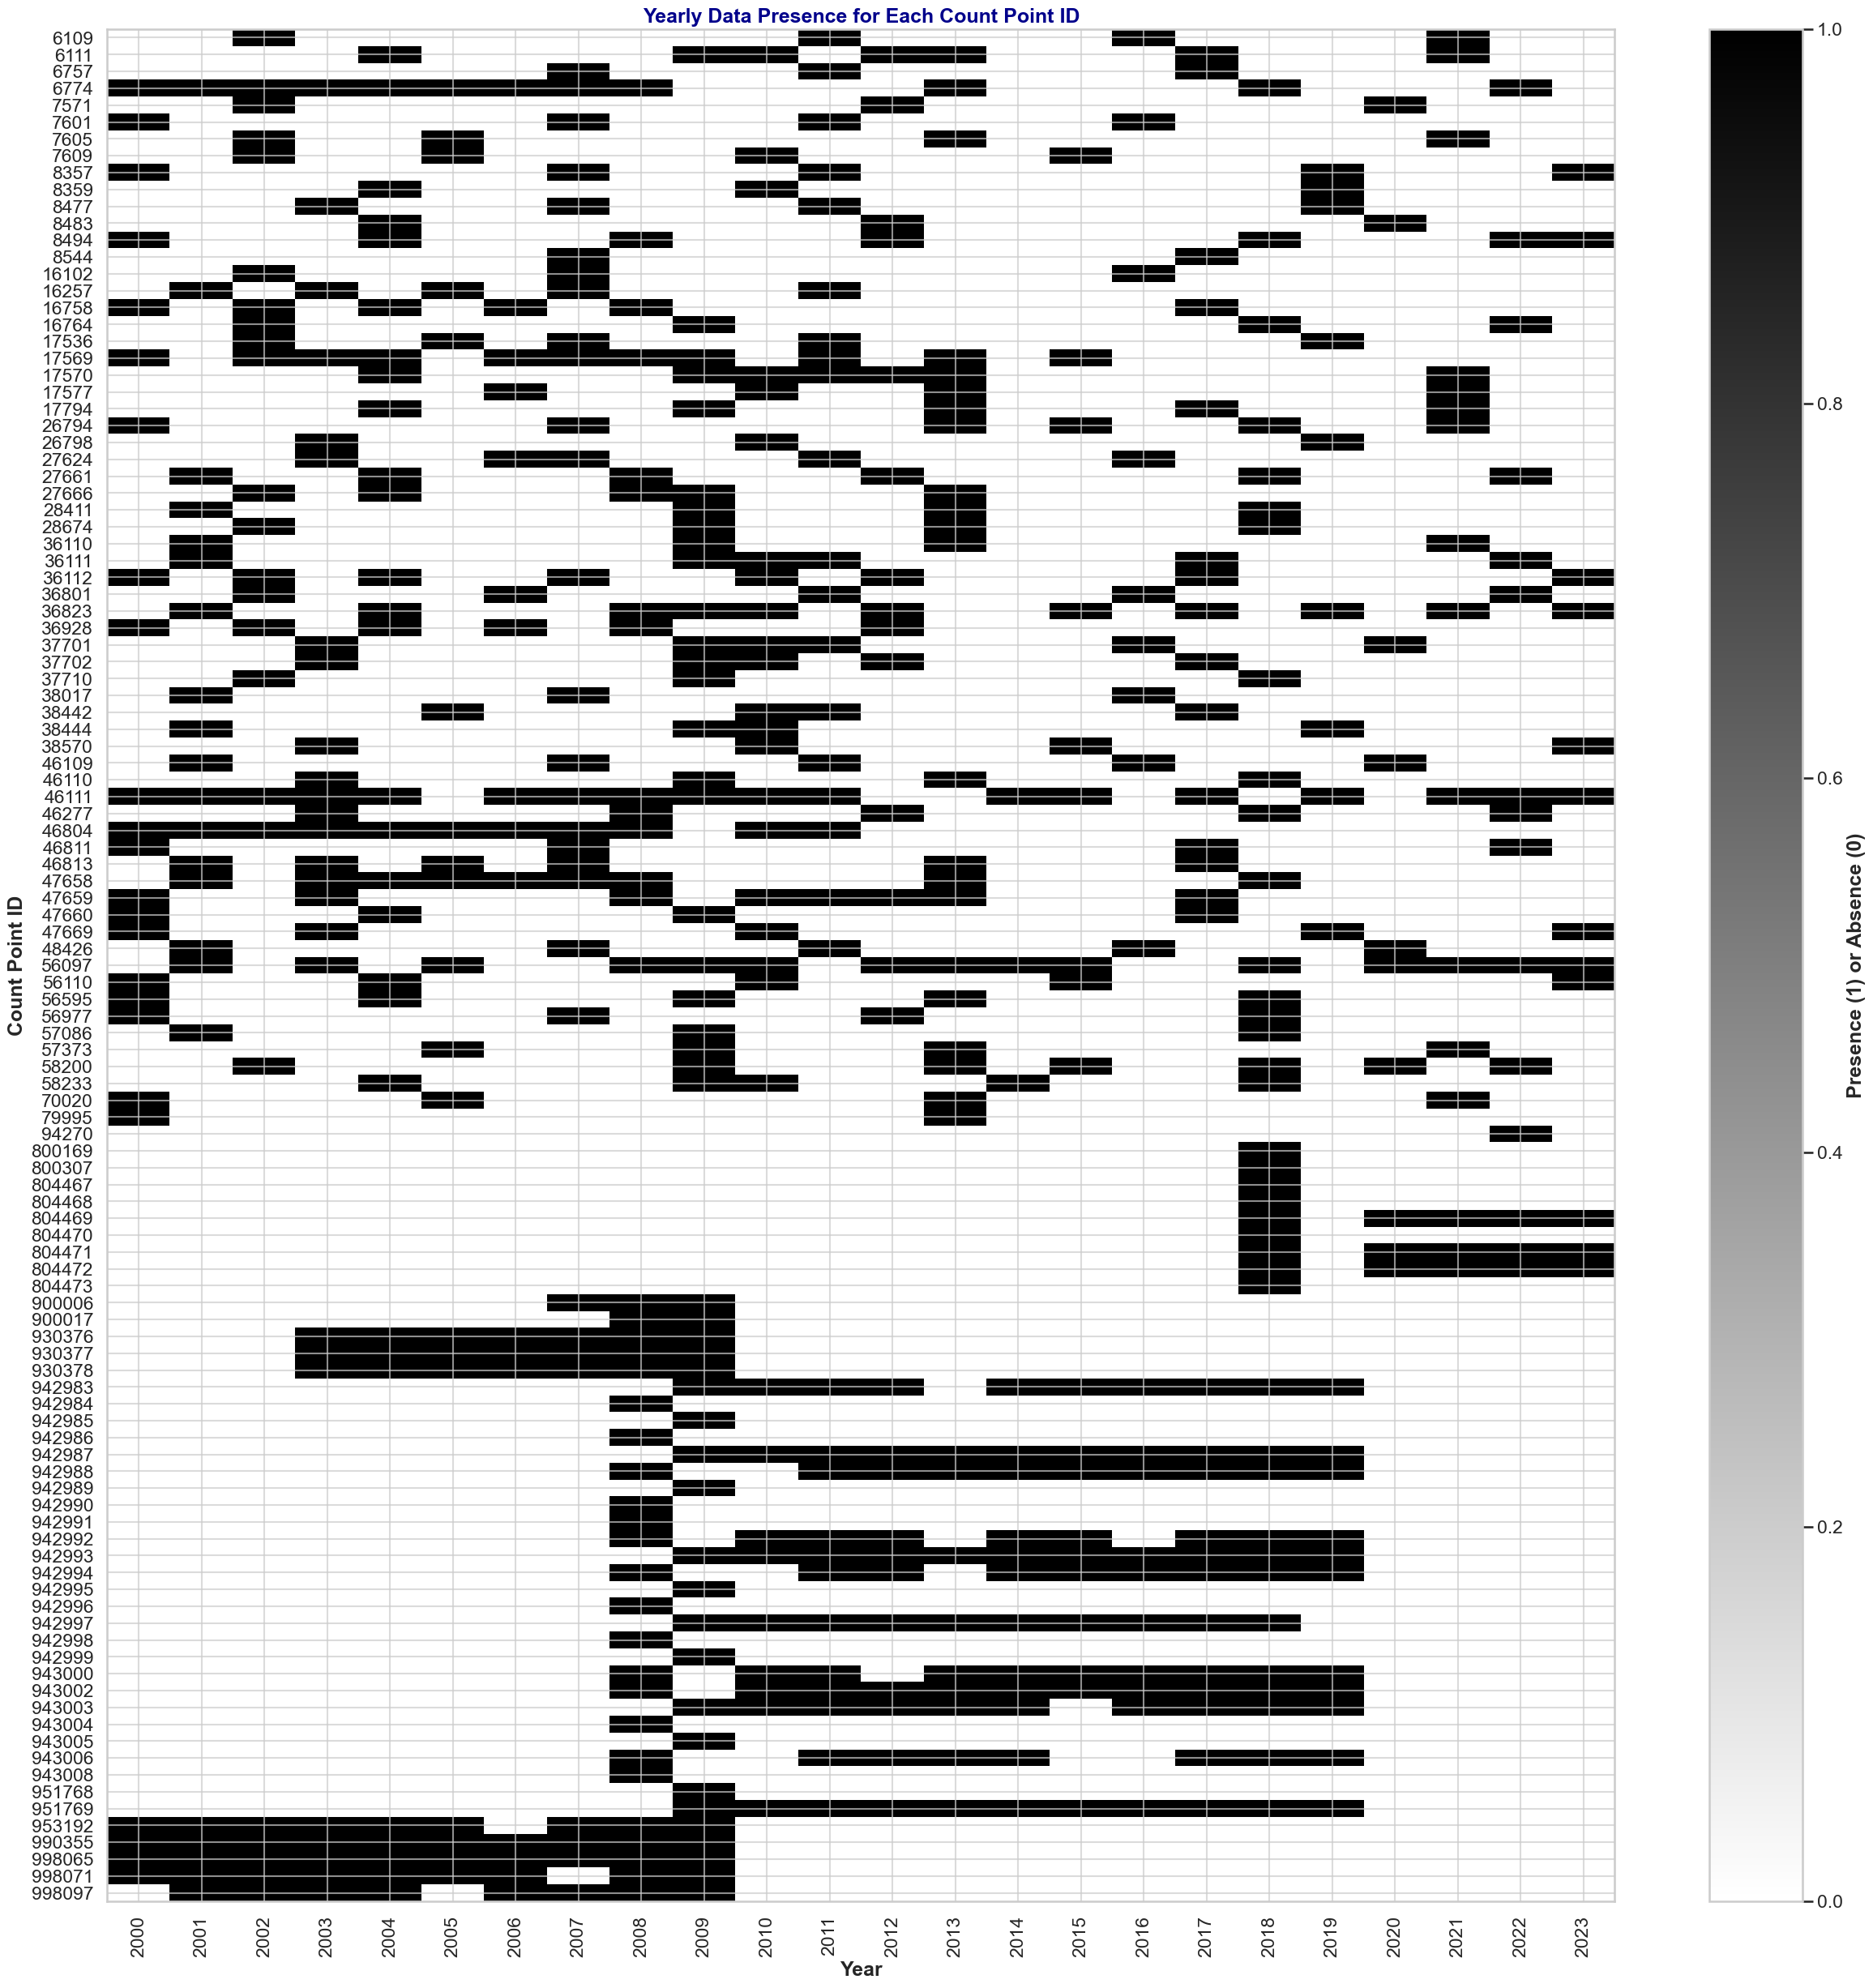

In [102]:
years = list(range(2000, 2024))
# Create an empty DataFrame for the heatmap data
heatmap_data = pd.DataFrame(0, index=tdf['count_point_id'], columns=years)


# Populate the heatmap data based on presence of years
for _, row in tdf.iterrows():
    for year in row['year']:
        if year in heatmap_data.columns:
            heatmap_data.loc[row['count_point_id'], year] = 1


# Plot the heatmap
plt.figure(figsize=(30, 30))
plt.imshow(heatmap_data, aspect='auto', cmap='binary', interpolation='none')
plt.colorbar(label='Presence (1) or Absence (0)')
plt.xlabel('Year')
plt.ylabel('Count Point ID')
plt.xticks(ticks=np.arange(len(years)), labels=years, rotation=90)
plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)  # Use count_point_id as labels
plt.title('Yearly Data Presence for Each Count Point ID')
plt.show()

### 3.3 Counter Points (Sensors) Data Analysis
The bar chartbelow titled **"Outdated vs Current Sensors"** provides an overview of the status of traffic sensors based on their latest data availability, using 2013 as a cutoff to classify sensors as either "Outdated" or "Current." The 10-year threshold was chosen because, in traffic engineering, a decade often marks a point where data can become less representative of current conditions due to evolving traffic patterns, infrastructure changes, and shifts in vehicle technology. Sensors with data up to or beyond 2013 are labeled as "Current," indicating they still provide relevant insights, while those with only pre-2013 data are considered "Outdated" and may require updating to maintain data accuracy. The chart shows two bars, with the longer, light blue bar representing "Current Sensors," and a shorter, red bar for "Outdated Sensors," allowing a quick assessment of the sensor network’s data currency. This analysis supports decision-making for sensor maintenance and upgrade planning, ensuring data reliability in traffic monitoring systems.

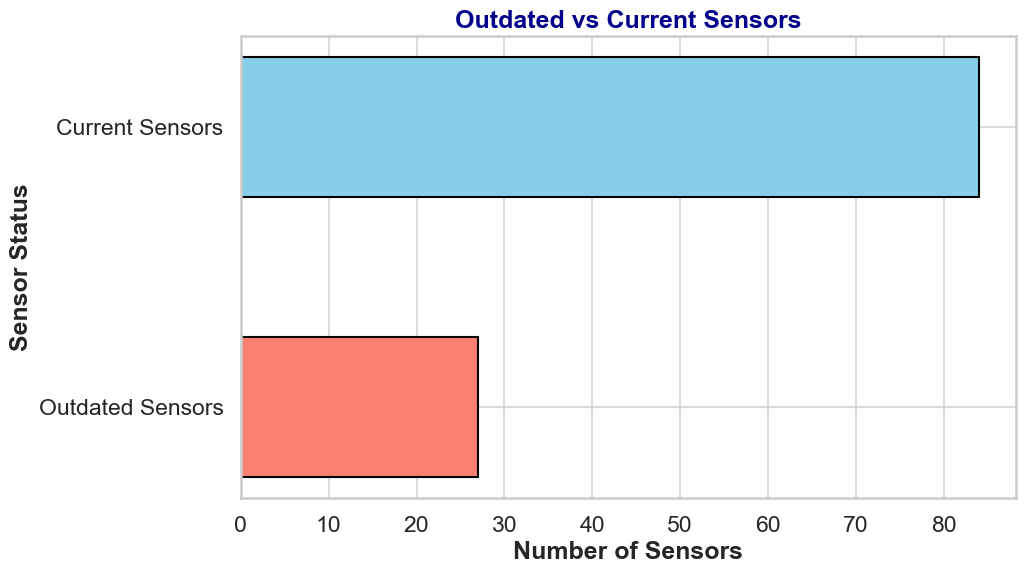

In [65]:
year_threshold=2013

x = [tdf[tdf['max_year'] < year_threshold].shape[0], tdf[tdf['max_year'] >= year_threshold].shape[0]]
y = ['Outdated Sensors', 'Current Sensors']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Outdated vs Current Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Sensor Status')
plt.show()

### 3.4 Analysis of Outdated Sensor Distribution by Road Type
The bar chart titled **"Number of Major and Minor Roads with Outdated Sensors Data"** displays the count of outdated sensors across major and minor roads. In the chart, the x-axis represents the **Number of Outdated Sensors** while the y-axis differentiates **Road Type** into "Major Roads" and "Minor Roads." The shorter blue bar for major roads and the longer red bar for minor roads indicate that a greater number of outdated sensors are installed on minor roads compared to major roads, providing a quick visual comparison of outdated sensor distribution by road type.

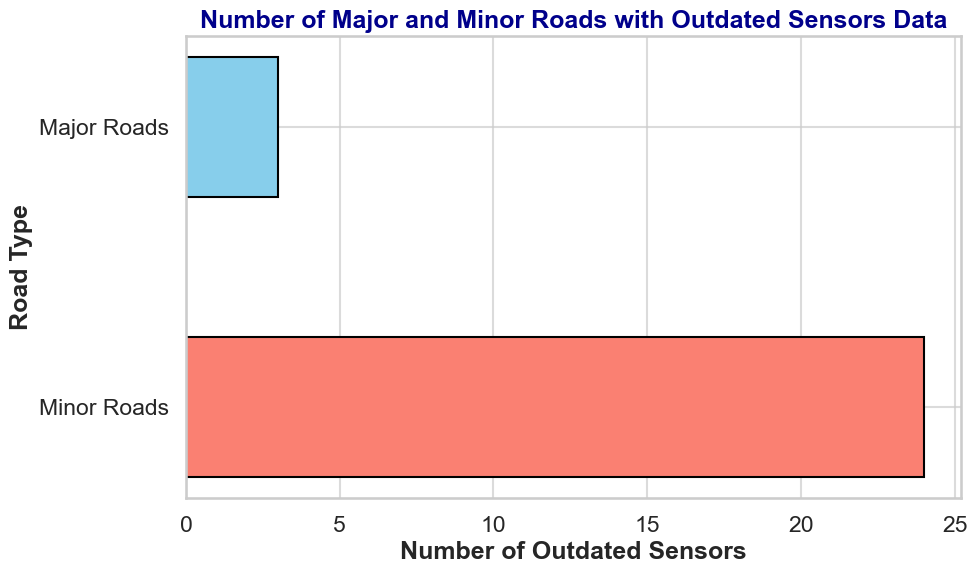

In [66]:
outdated_sensors=tdf[tdf['max_year']<year_threshold]['count_point_id'].values

odt_sens_vc= dict(count_df[count_df['count_point_id'].isin(outdated_sensors)]['road_type'].value_counts())
x = [odt_sens_vc['Minor'], odt_sens_vc['Major']]
y = ['Minor Roads', 'Major Roads']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Number of Major and Minor Roads with Outdated Sensors Data')
plt.xlabel('Number of Outdated Sensors')
plt.ylabel('Road Type')
plt.show()



### 3.5 Outdated Sensors AADF Traffic Trends

The following charts display the Average Annual Daily Flow (AADF) for outdated sensors, offering insights into their data trends over time. Each plot represents a different sensor's AADF across years, highlighting that many sensors have only a few data points or exhibit a consistent traffic trend over the years. Notably, sensors 16257, 36928, and 46804 have continuous data availability from 2000 to 2023, which could serve as reliable references for interpolating missing values for other sensors using a sample-weighting approach. This overview reveals the sparse data landscape for outdated sensors, supporting strategic decisions on data imputation.

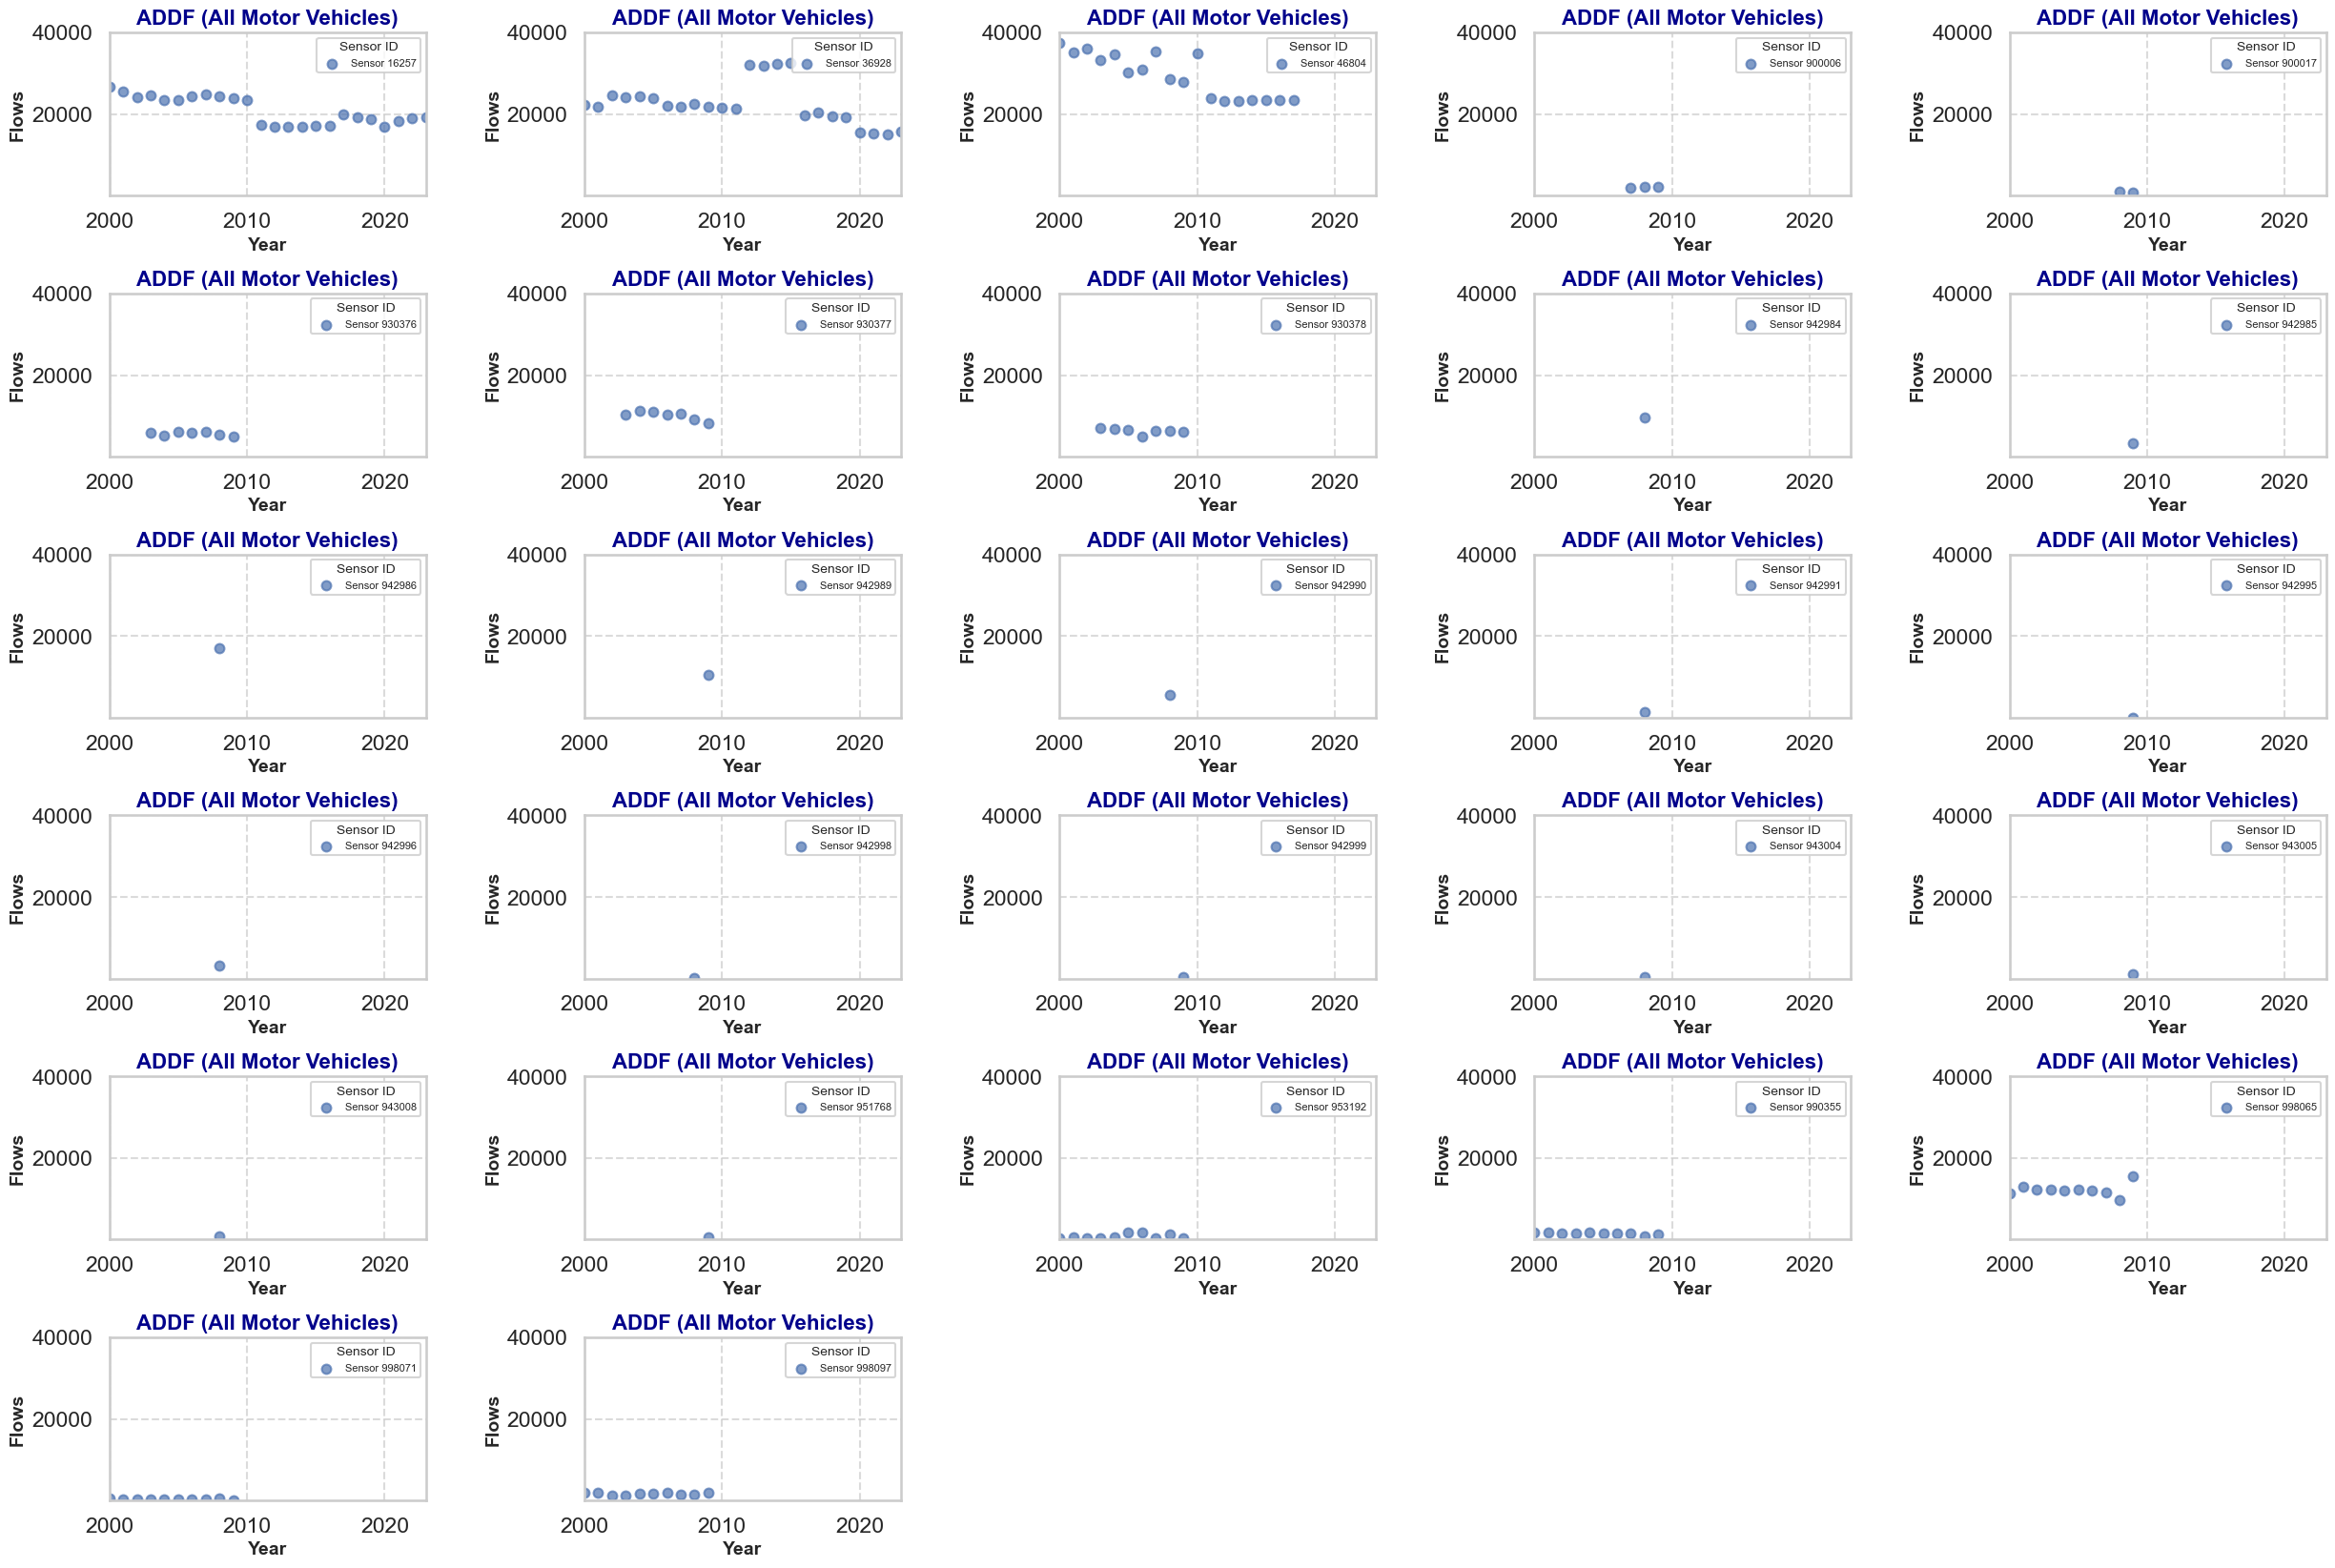

In [69]:
adtf=pd.read_csv('data/avg_annual_daily.csv')[['count_point_id','year','road_name','road_type','all_motor_vehicles']]
# Plotting a scatter plot of 'all_motor_vehicles' vs 'year' for each 'count_point_id'
adtf= adtf[adtf['count_point_id'].isin(outdated_sensors)]

fig, ax = plt.subplots(6, 5, figsize=(30, 20))  # Create a 3x3 grid of subplots
plt.subplots_adjust(wspace=0.5,hspace=0.6)

ax = ax.flatten()
count=0
for sensor_id, sensor_data in adtf.groupby('count_point_id'):
    ax[count].scatter(sensor_data['year'], sensor_data['all_motor_vehicles'], label=f"Sensor {sensor_id}", s=50, alpha=0.7)

    # Adding titles and labels with increased font sizes
    ax[count].set_title("AADF (All Motor Vehicles)", fontsize=16, fontweight='bold', color='darkblue')
    ax[count].set_xlabel("Year", fontsize=14)  
    ax[count].set_ylabel("Flows", fontsize=14)  
    ax[count].legend(title="Sensor ID", fontsize=8, title_fontsize=10)
    ax[count].grid(True, linestyle='--', alpha=0.7)
    ax[count].set_ylim([100, 40000])
    ax[count].set_xlim([2000, 2023])

    count += 1

for i in range(count, len(ax)):
    ax[i].axis('off')
plt.show()

## 4. Data Imputation 

### 4.1 Reading Average Annual Daily Flow Data

In [109]:
annaul_daily_df=pd.read_csv('data/aadf_direction.csv', dtype={'start_junction_road_name': 'string', 'end_junction_road_name': 'string'})#[['count_point_id','year','road_name','road_type','all_motor_vehicles']]
annaul_daily_df=annaul_daily_df[annaul_daily_df['count_point_id'].isin(df['count_point_id'])]
cur_col=annaul_daily_df.columns
repl_col=[c.lower() for c in cur_col]
my_dict = dict(zip(cur_col, repl_col))
annaul_daily_df.rename(columns=my_dict, inplace=True)

annaul_daily_df['total_cars_aadf']= annaul_daily_df.apply(getTotalCars,axis=1)
annaul_daily_df=annaul_daily_df[['count_point_id','direction_of_travel','year','total_cars_aadf']]
annaul_daily_df

,count_point_id,direction_of_travel,year,total_cars_aadf
18343,6109,E,2000,13638.2
18344,6109,W,2000,15465.8
18345,6109,E,2001,13542.4
18346,6109,W,2001,15334.7
18347,6109,E,2002,12815.1
...,...,...,...,...
1049914,998097,S,2007,662.2
1049915,998097,N,2008,922.6
1049916,998097,S,2008,592.6
1049917,998097,N,2009,1206.7


In [110]:
tdf=pd.DataFrame(annaul_daily_df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
#tdf=tdf.merge(annaul_daily_df[['count_point_id','road_name','road_type','all_motor_vehicles']],on='count_point_id', how='left')

tdf

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
1,6111,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
2,6757,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
4,7571,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
...,...,...,...,...,...
106,953192,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
107,990355,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
108,998065,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
109,998071,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009


In [113]:

current_sensors=tdf[tdf['max_year']>=2013]['count_point_id'].values # Getting all the current sensors' ID
raw_df=df[df['count_point_id'].isin(current_sensors)].copy() # Keeping raw traffic count valuee from only current sensors

# As shown in section 3.2, even current sensors have data for some years missing. The following code generates a new dataframe with  all the combinations of years and hours from 2013 to 2023.
years = range(2013, 2024)
hours = range(7, 19)  # 7 am to 6 pm
unique_points = raw_df[['count_point_id', 'direction_of_travel']].drop_duplicates() # Get unique combinations of count_point_id and direction_of_travel
complete_data = pd.MultiIndex.from_product( 
    [unique_points['count_point_id'], unique_points['direction_of_travel'], years, hours],
    names=['count_point_id', 'direction_of_travel', 'year', 'hour']
).to_frame(index=False) # Create a new DataFrame to cover all possible combinations
complete_data.drop_duplicates(subset=['count_point_id','direction_of_travel','year','hour'],inplace=True) # Deleting any duplicate record generated
complete_data # Now we have an ideal dataframe that contains each hour for each year from 2013 to 2013 for each sensor

,count_point_id,direction_of_travel,year,hour
0,6109,E,2013,7
1,6109,E,2013,8
2,6109,E,2013,9
3,6109,E,2013,10
4,6109,E,2013,11
...,...,...,...,...
5877031,951769,S,2023,14
5877032,951769,S,2023,15
5877033,951769,S,2023,16
5877034,951769,S,2023,17


In [136]:

# The following code merges the complete data with our original raw data that has missing years.
# The resultant dataframe will have complete years and hours for all the sensors. Traffic count 
# values for the years missing from our original raw data will be NA.
merged_df = pd.merge(complete_data, raw_df, on=['count_point_id', 'direction_of_travel', 'year', 'hour'], how='left') # Merge this complete set with the original data

# AADF us the annual average daily flow data for all the sensors for (almost) all the years. 
# The The line below merges AADF value with our merged_df dataframe to add AADF for every year 
# that will later be used to impute missing raw count values using sample weighting
merged_df=merged_df.merge(annaul_daily_df,on=['count_point_id','year','direction_of_travel'],how='left')
merged_df[merged_df['year']==2020]

,count_point_id,direction_of_travel,year,hour,count_date,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio
84,6109,E,2020,7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,6109,E,2020,8,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,6109,E,2020,9,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,6109,E,2020,10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,6109,E,2020,11,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,951769,S,2020,14,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45896,951769,S,2020,15,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45897,951769,S,2020,16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45898,951769,S,2020,17,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Our orignal data does not have daily total traffic feature. The code below calculates the
# total number of daily vehicles for each year. This number will be used to calculate hourly 
# percentage with respect to total daily traffic. That percentage later be used to estimate 
# hourly traffic count values for the missing data
avg_daily_cars = (
    merged_df.groupby(['count_point_id', 'year','direction_of_travel'])['total_cars']
    .sum()
    .reset_index(name='avg_daily_cars_act')
)

merged_df = merged_df.merge(avg_daily_cars, on=['count_point_id','direction_of_travel', 'year'], how='left') # This will add new column 'avg_daily_cars_act' to original data.
merged_df['hourly_percentage'] = (merged_df['total_cars'] / merged_df['avg_daily_cars_act']) # Calculating hourly percentage

# For each sensor, the following code calculates the mean hourly percentage using all the 
# non-NA values of hours from all the years. E.g., in 2013, for sensor 6109, hourly percentage 
# of total traffic for hour 7 was 0.7 and for year 2014 it was 0.8, the mean hourly percentage for hour 7 would be 0.75
hourly_percentage = (
    merged_df.dropna(subset=['hourly_percentage'])
    .groupby(['count_point_id','direction_of_travel', 'hour'])['hourly_percentage']
    .mean()
    .reset_index()
)


,count_point_id,year,direction_of_travel,avg_daily_cars_act
0,6109,2013,E,0.0
1,6109,2013,N,0.0
2,6109,2013,S,0.0
3,6109,2013,W,0.0
4,6109,2014,E,0.0
...,...,...,...,...
3823,951769,2022,W,0.0
3824,951769,2023,E,0.0
3825,951769,2023,N,0.0
3826,951769,2023,S,0.0


In [122]:
# Step 5: Merge these hourly percentages with the main dataset
merged_df = merged_df.merge(hourly_percentage, on=['count_point_id','direction_of_travel', 'hour'], suffixes=('', '_mean'), how='left')

merged_df[merged_df['year']==2019]

,count_point_id,direction_of_travel,year,hour,count_date,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean
72,6109,E,2019,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.075276
73,6109,E,2019,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.086319
74,6109,E,2019,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.074999
75,6109,E,2019,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.084058
76,6109,E,2019,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45883,951769,S,2019,14,2019-06-19,U,Minor,NaN,NaN,522287.0,173874.0,51.450655,-0.241543,NaN,NaN,0.0,1.0,24.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,33.6,U,1150.0,0.029217,315.4,262.6,0.127951,0.099895
45884,951769,S,2019,15,2019-06-19,U,Minor,NaN,NaN,522287.0,173874.0,51.450655,-0.241543,NaN,NaN,1.0,0.0,21.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,23.6,U,1150.0,0.020522,315.4,262.6,0.089871,0.085524
45885,951769,S,2019,16,2019-06-19,U,Minor,NaN,NaN,522287.0,173874.0,51.450655,-0.241543,NaN,NaN,0.0,1.0,15.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0,19.8,U,1150.0,0.017217,315.4,262.6,0.075400,0.079475
45886,951769,S,2019,17,2019-06-19,U,Minor,NaN,NaN,522287.0,173874.0,51.450655,-0.241543,NaN,NaN,0.0,3.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,24.4,U,1150.0,0.021217,315.4,262.6,0.092917,0.087450


In [123]:
# Step 6: Impute missing hourly values based on total_cars_addf and hourly percentage
merged_df['imputed_cars'] = merged_df.apply(
    lambda x: x['hourly_percentage_mean'] * x['total_cars_aadf'] if pd.isna(x['total_cars']) else x['total_cars'],
    axis=1
)
merged_df

,count_point_id,direction_of_travel,year,hour,count_date,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,NaN
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,NaN
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,NaN
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,NaN


In [124]:
merged_df['imputed_cars'] = merged_df.groupby(['count_point_id','hour'])['imputed_cars']\
                        .transform(lambda x: x.fillna(x.mean()))

merged_df

,count_point_id,direction_of_travel,year,hour,count_date,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,35.385714
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,43.785714
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,47.150000
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,46.085714


In [125]:
len(merged_df['count_point_id'].unique())

87

In [126]:
merged_df.dropna(subset=['imputed_cars'],inplace=True)
len(merged_df['count_point_id'].unique())

84

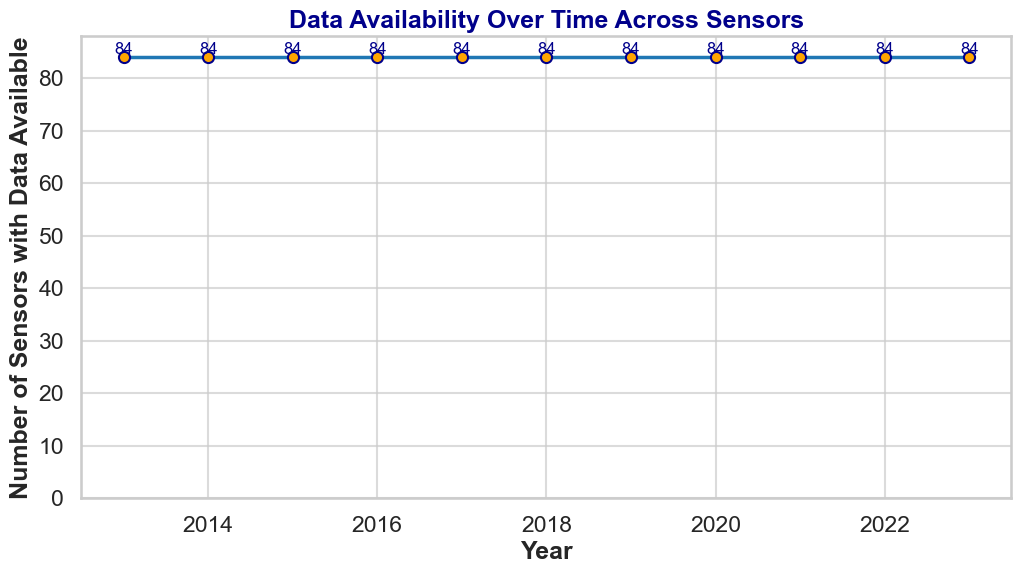

In [127]:
tdf=pd.DataFrame(merged_df[~merged_df['imputed_cars'].isna()].groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability

# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

In [128]:
merged_df.to_csv('data/processed_raw_count.csv',index=False)

In [129]:
df=merged_df.copy()

In [130]:
major_rd_df=df[(df['road_type']=='Major')&(~df['count_point_id'].isin(outdated_sensors))].copy()
minor_rd_df=df[(df['road_type']=='Minor')&(~df['count_point_id'].isin(outdated_sensors))].copy()

In [131]:
major_rd_df.columns

Index(['count_point_id', 'direction_of_travel', 'year', 'hour', 'count_date',
       'road_name', 'road_type', 'start_junction_road_name',
       'end_junction_road_name', 'easting', 'northing', 'latitude',
       'longitude', 'link_length_km', 'link_length_miles', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles', 'total_cars', 'road_classification',
       'avg_road_capacity', 'congestion_ratio', 'total_cars_aadf',
       'avg_daily_cars_act', 'hourly_percentage', 'hourly_percentage_mean',
       'imputed_cars'],
      dtype='object')

## Major Roads Morning Peak Hours Congestion Spots

In [132]:
# Major Roads
df_grouped_major=pd.DataFrame(major_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_major.reset_index(inplace=True)
df_grouped_major['hour_category']=df_grouped_major['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_major=df_grouped_major[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]


df_maj_morning=df_grouped_major[df_grouped_major['hour_category']=='morning_peak'].copy()
df_maj_morning['density']=df_maj_morning['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_morning['latitude'].mean(), df_maj_morning['longitude'].mean()], zoom_start=12)

for _, row in df_maj_morning.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

## Major Roads  Evening Hours Congestion Spots

In [133]:



df_maj_evening=df_grouped_major[df_grouped_major['hour_category']=='evening_peak'].copy()
df_maj_evening['density']=df_maj_evening['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_evening['latitude'].mean(), df_maj_evening['longitude'].mean()], zoom_start=12)

for _, row in df_maj_evening.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

## Minor Roads Morning Peak Hours Congestion Spots

In [134]:
# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]
df_grouped_minor


df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='morning_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

In [135]:

# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]

df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='evening_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m